# Fetch Jets

This is a very simple demo - which was reporting as not working in the wild. Here is the original:

```python
from servicex import ignore_cache
from func_adl_servicex_xaodr21 import SXDSAtlasxAODR21

ds = SXDSAtlasxAODR21('mc16_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.deriv.DAOD_PHYS.e3601_e5984_s3126_s3136_r10724_r10726_p4164', backend="xaod")

with ignore_cache():
     jets = (ds
             .SelectMany(lambda e: e.Jets())
             .Where(lambda j: (j.pt() / 1000) > 30)
             .Select(lambda j: j.pt() / 1000.0)
             .AsAwkwardArray('JetPt')
             .value())
```

In [1]:
from servicex import ignore_cache
from func_adl_servicex_xaodr21 import SXDSAtlasxAODR21

Get the dataset all configured.

This is the first change - make sure we are going after the R21 backend, and a new dataset (see below)

In [2]:
ds = SXDSAtlasxAODR21('mc16_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.deriv.DAOD_PHYS.e3601_s3126_r9364_p5313?files=1', backend="atlasr21")

Next, the query with the `ignore_cache` in place. Note that this takes a little time because calibrations are being run, which are *slow* (a file was taking about 3 minutes for me).

In [3]:
with ignore_cache():
    jets = (ds
            .SelectMany(lambda e: e.Jets())
            .Where(lambda j: (j.pt() / 1000) > 30)
            .Select(lambda j: j.pt() / 1000.0)
            .AsAwkwardArray('JetPt')
            .value())

mc16_13TeV.361106.Po...:   0%|          | 0/9000000000.0 [00:00]

        mc16_13TeV.361106.Po... Downloaded:   0%|          | 0/9000000000.0 [00:00]

And the proof is in the plotting...

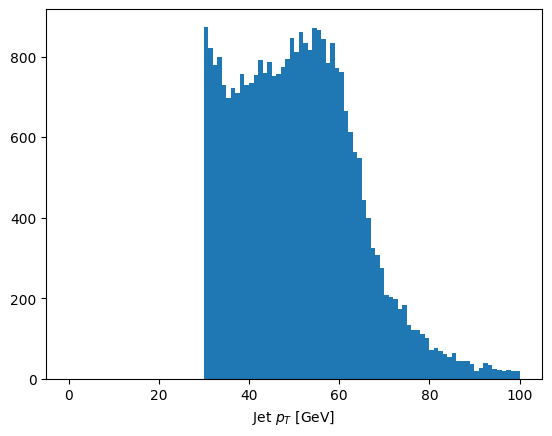

In [4]:
import matplotlib.pyplot as plt

plt.hist(jets.JetPt, bins=100, range=(0, 100))
plt.xlabel('Jet $p_T$ [GeV]')
plt.show()

## Problems Found

I'm not 100% this is all the things that went wrong. But these are the things I faced. I did start from a virtual-env that hadn't been touched in months for this demo.

### Wrong package versions

I started this by using an old version of `func_adl_servicex` - the basic error that I think was at the root here was similar to what I was seeing. I ended up with the following packages:

In [5]:
!pip list

Package                   Version
------------------------- --------------
aiofiles                  22.1.0
aiohttp                   3.8.3
aiosignal                 1.3.1
aiosqlite                 0.18.0
anyio                     3.6.2
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
arrow                     1.2.3
asttokens                 2.2.1
async-timeout             4.0.2
attrs                     22.2.0
awkward                   1.10.2
Babel                     2.11.0
backcall                  0.2.0
backoff                   2.2.1
beautifulsoup4            4.11.2
bleach                    6.0.0
cachetools                5.3.0
certifi                   2022.12.7
cffi                      1.15.1
charset-normalizer        2.1.1
colorama                  0.4.6
comm                      0.1.2
configparser              5.3.0
confuse                   1.3.0
contourpy                 1.0.7
cycler                    0.11.0
debugpy                   1.6.6
decorator      

### Old `servicex.yaml` file

I'm not 100% sure this is was causing a problem. But with the most up-to-date `servicex` package there is also a new way to talking to the modern backends. So, it is best to juts adopt this - so go to the dashboard and download the `servicex.yaml` file. You'll see lots of differences.

```yaml
api_endpoints:
  - name: atlasr21
    endpoint: https://servicex.af.uchicago.edu/
    token: <token>
    codegen: atlasr21
    return_data: root-file
  - name: atlasr22
    endpoint: https://servicex.af.uchicago.edu/
    token: <token>
    codegen: atlasr22
    return_data: root-file
  - name: atlasxaod
    endpoint: https://servicex.af.uchicago.edu/
    token: <token>
    codegen: atlasxaod
    return_data: root-file
  - name: cms
    endpoint: https://servicex.af.uchicago.edu/
    token: <token>
    codegen: cms
    return_data: root-file
  - name: cmssw-5-3-32
    endpoint: https://servicex.af.uchicago.edu/
    token: <token>
    codegen: cmssw-5-3-32
    return_data: root-file
  - name: python
    endpoint: https://servicex.af.uchicago.edu/
    token: <token>
    codegen: python
    return_data: root-file
  - name: uproot
    endpoint: https://servicex.af.uchicago.edu/
    token: <token>
    codegen: uproot
    return_data: root-file

```

### Dataset

Ok - this is a real bug in `servicex` - it just hung w/out reporting an error - but caused by this:

```bash
[gwatts@AMDOfficeCore .globus]$ rucio list-files mc16_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.deriv.DAOD_PHYS.e3601_e5984_s3126_s3136_r10724_r10726_p4164
+--------------+--------+-----------+------------+----------+
| SCOPE:NAME   | GUID   | ADLER32   | FILESIZE   | EVENTS   |
|--------------+--------+-----------+------------+----------|
+--------------+--------+-----------+------------+----------+
Total files : 0
Total size : 0.000 B
[gwatts@AMDOfficeCore .globus]$
```

So - we need a new dataset! This is a problem with a number of our demos - the datasets keep getting obsoleted (ATLAS is fairly aggressive about this). I did find one:

```bash
[gwatts@AMDOfficeCore .globus]$ rucio list-files mc16_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.deriv.DAOD_PHYS.e3601_s3126_r9364_p5313
+---------------------------------------------------+--------------------------------------+-------------+------------+----------+
| SCOPE:NAME                                        | GUID                                 | ADLER32     | FILESIZE   | EVENTS   |
|---------------------------------------------------+--------------------------------------+-------------+------------+----------|
| mc16_13TeV:DAOD_PHYS.30889941._000001.pool.root.1 | CF95C46F-D96F-EE49-8D7A-9935D9BAC9C4 | ad:d6581dd8 | 461.832 MB | 20000    |
| mc16_13TeV:DAOD_PHYS.30889941._000002.pool.root.1 | 898A9A01-69D6-F54B-AFC4-1471FBE8E989 | ad:d210a626 | 462.689 MB | 20000    |
| mc16_13TeV:DAOD_PHYS.30889941._000003.pool.root.1 | F2945F8B-975B-A749-AF18-FE28F99E141E | ad:753e1801 | 462.406 MB | 20000    |
| mc16_13TeV:DAOD_PHYS.30889941._000004.pool.root.1 | E820BB15-D863-8748-B436-A09415A6044A | ad:f0dcffdf | 462.843 MB | 20000    |
| mc16_13TeV:DAOD_PHYS.30889941._000005.pool.root.1 | 1B8DF356-35C5-944B-B4E4-D801FBB1D601 | ad:6c76896f | 463.842 MB | 20000    |
| mc16_13TeV:DAOD_PHYS.30889941._000006.pool.root.1 | 69585978-246E-904E-A518-32D7204D7A74 | ad:14c43f5b | 1.389 GB   | 60000    |
| mc16_13TeV:DAOD_PHYS.30889941._000007.pool.root.1 | 5237823F-194A-734D-BB5A-7916810042F1 | ad:b66e8966 | 1.389 GB   | 60000    |
| mc16_13TeV:DAOD_PHYS.30889941._000008.pool.root.1 | 0CAB9EC1-23E8-7E45-96FC-4BD01BC4CCDD | ad:e0c98c67 | 1.382 GB   | 60000    |
| mc16_13TeV:DAOD_PHYS.30889941._000009.pool.root.1 | 624E9A9D-CE17-4741-AD8F-934E2DF0E3B4 | ad:f03f30e1 | 1.388 GB   | 60000    |
| mc16_13TeV:DAOD_PHYS.30889941._000010.pool.root.1 | 586DA5F0-F1E5-FE49-AE49-B149623F0B12 | ad:6c1e55ce | 1.384 GB   | 60000    |
...
| mc16_13TeV:DAOD_PHYS.30889856._000281.pool.root.1 | 7CAE7274-5345-7E45-ACFD-717079B32E01 | ad:302beca3 | 1.155 GB   | 50000    |
| mc16_13TeV:DAOD_PHYS.30889856._000283.pool.root.1 | AE38B795-EDDE-9C45-AA07-6EB1805C80F7 | ad:e4c2d154 | 601.096 MB | 26000    |
| mc16_13TeV:DAOD_PHYS.30889856._000284.pool.root.1 | FD6248BE-D582-654E-B461-270E67CE9930 | ad:7bdf0ef2 | 232.683 MB | 10000    |
+---------------------------------------------------+--------------------------------------+-------------+------------+----------+
Total files : 5546
Total size : 7.159 TB
Total events : 309798150
```

Note it is huge - which is why for this demo I used the `?files=1` argument for the test.